In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CHANNELS=3

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato leaf /Tomato Leaf Deasise Dataset/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
   '/content/drive/MyDrive/Tomato leaf /Tomato Leaf Deasise Dataset/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))
test_generator = validation_datagen.flow_from_directory(
   '/content/drive/MyDrive/Tomato leaf /Tomato Leaf Deasise Dataset/test',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))

Found 7560 images belonging to 9 classes.
Found 1080 images belonging to 9 classes.
Found 2160 images belonging to 9 classes.


In [4]:
x,y=test_generator.next()
x.shape

(32, 224, 224, 3)

In [5]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [6]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(9, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [7]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=test_generator,
    epochs=5
)

Epoch 1/5
237/237 [==============================] - 5028s 21s/step - loss: 0.5335 - accuracy: 0.8257 - val_loss: 0.3360 - val_accuracy: 0.8903
Epoch 2/5
237/237 [==============================] - 174s 735ms/step - loss: 0.2087 - accuracy: 0.9339 - val_loss: 0.3483 - val_accuracy: 0.8685
Epoch 3/5
237/237 [==============================] - 172s 728ms/step - loss: 0.1471 - accuracy: 0.9504 - val_loss: 0.3196 - val_accuracy: 0.8875
Epoch 4/5
237/237 [==============================] - 180s 761ms/step - loss: 0.1278 - accuracy: 0.9560 - val_loss: 0.2009 - val_accuracy: 0.9287
Epoch 5/5
237/237 [==============================] - 179s 758ms/step - loss: 0.1072 - accuracy: 0.9627 - val_loss: 0.1769 - val_accuracy: 0.9398


In [8]:
loss, accuracy = model.evaluate(test_generator )

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

68/68 [==============================] - 50s 745ms/step - loss: 0.1769 - accuracy: 0.9398
Accuracy: 0.9398148059844971
Loss: 0.17688877880573273


In [9]:
test_generator.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Healthy': 2,
 'Late_blight': 3,
 'Leaf_Mold': 4,
 'Septoria_leaf_spot': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8}

In [11]:
import numpy as np
from sklearn import metrics

predictions = model.predict_generator(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels = ['Bacterial_spot','Early_blight','Healthy','Late_blight', 'Leaf_Mold','Septoria_leaf_spot','Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

<ipython-input-11-1fc373ec18fc>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


                               precision    recall  f1-score   support

               Bacterial_spot       1.00      0.88      0.93       240
                 Early_blight       0.85      0.93      0.88       240
                      Healthy       0.94      1.00      0.97       240
                  Late_blight       0.98      0.90      0.94       240
                    Leaf_Mold       1.00      0.93      0.96       240
           Septoria_leaf_spot       0.91      0.98      0.95       240
                  Target_Spot       0.86      0.93      0.89       240
Tomato_Yellow_Leaf_Curl_Virus       1.00      0.94      0.97       240
          Tomato_mosaic_virus       0.96      0.99      0.98       240

                     accuracy                           0.94      2160
                    macro avg       0.94      0.94      0.94      2160
                 weighted avg       0.94      0.94      0.94      2160



<Axes: >

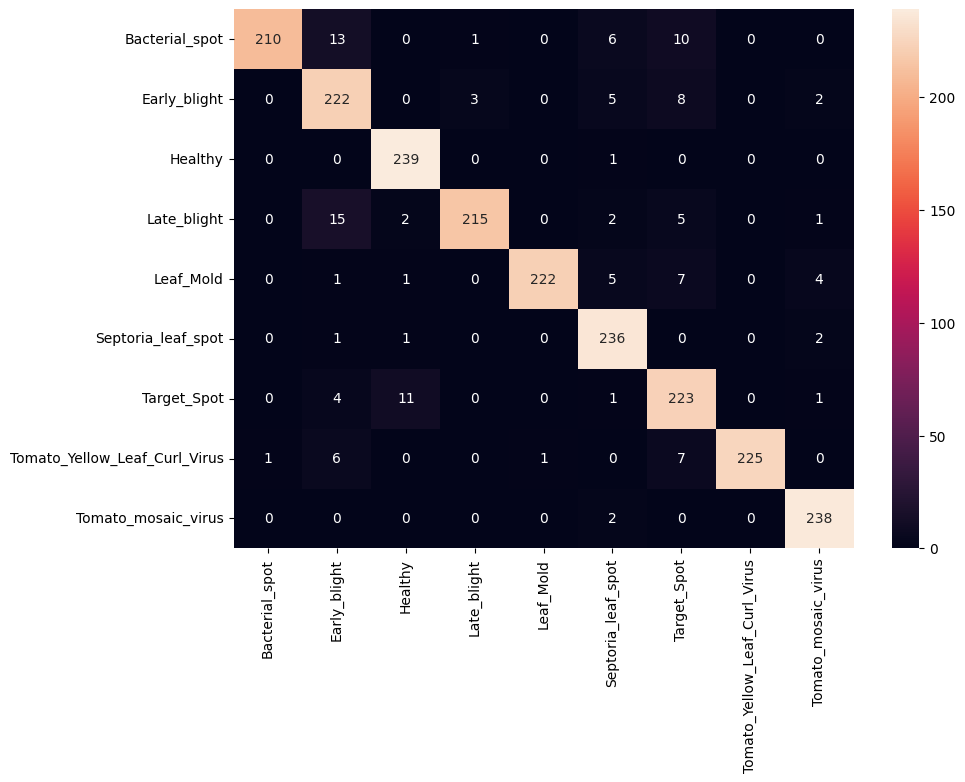

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Bacterial_spot','Early_blight','Healthy','Late_blight', 'Leaf_Mold','Septoria_leaf_spot','Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus']],
                  columns = [i for i in ['Bacterial_spot','Early_blight','Healthy','Late_blight', 'Leaf_Mold','Septoria_leaf_spot','Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

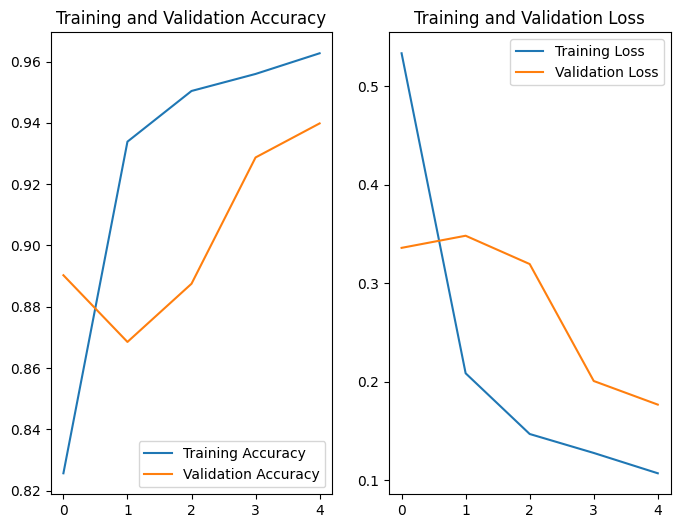

In [16]:
EPOCHS=5
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

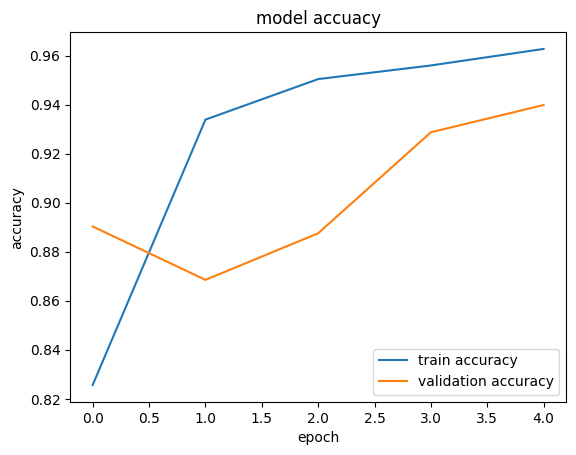

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

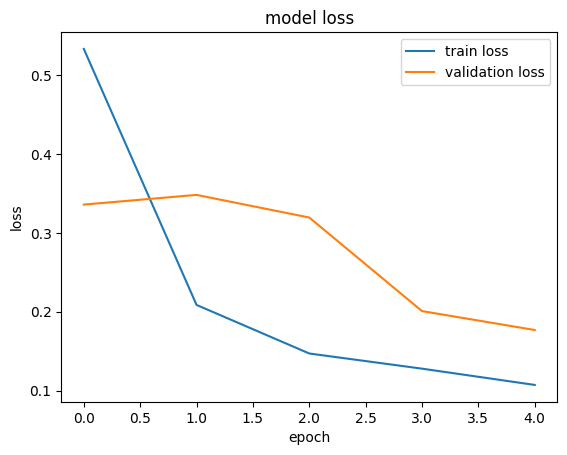

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()